In [25]:
from pandas_datareader import data
import numpy as np 
import scipy as sp 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.notebook_repr_html', True)

from datetime import date, datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})  

from cryptocompare import get_daily_trades
import quandl
from indicators import *

import requests
import talib
import plot


The purpose of this notebook is look at an analyze the correlation between the bitcoin market and the two most important stock market indices the S&P 500 and the Nasdaq Composite. While the two asset classes are seemingly uncorrelated when looking at the aggregate correlation statistic they may be correlated at certain periods of time and uncorrelated during others.

Contents
- Data acquisition
- Plot of prices 
- Aggreate correlation
- Rolling correlation
- Grouped correlations 
- Plot most correlated periods


### Data acquisition

In [24]:
quandl_token = 'mdsDJzaw8USr9yacuGnw'
spx = data.DataReader('SPX', data_source='quandl', access_key=quandl_token)

RemoteDataError: Unable to read URL: https://www.quandl.com/api/v3/datasets/WIKI/SPX.csv?start_date=2010-01-01&end_date=2018-09-04&order=asc
Response Text:
b'code,message\n"QELx01","You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests."'

In [56]:
ndx = data.DataReader('NDX', data_source='morningstar')

Exception: Request Error!: 404 : Not Found

In [28]:
btc = get_daily_trades('BTC', all_data=True)['close']
spx = data.DataReader('SPX', data_source='morningstar')['Close']
ndx = data.DataReader('IXIC', data_source='morningstar')['Close']

Exception: Request Error!: 404 : Not Found

In [41]:
spx.reset_index('Symbol').drop('Symbol', axis=1).head()

,Close
Date,
2010-01-01,1115.1027
2010-01-04,1132.9855
2010-01-05,1136.5234
2010-01-06,1137.1378
2010-01-07,1141.6949


In [48]:
btc.shape

(2972,)

In [45]:
spx.shape

(2262,)

In [67]:
df = pd.concat([btc.rename('BTC'), spx.reset_index('Symbol')['Close'].rename('SPX')], axis=1).dropna()
df.shape

(2121, 2)

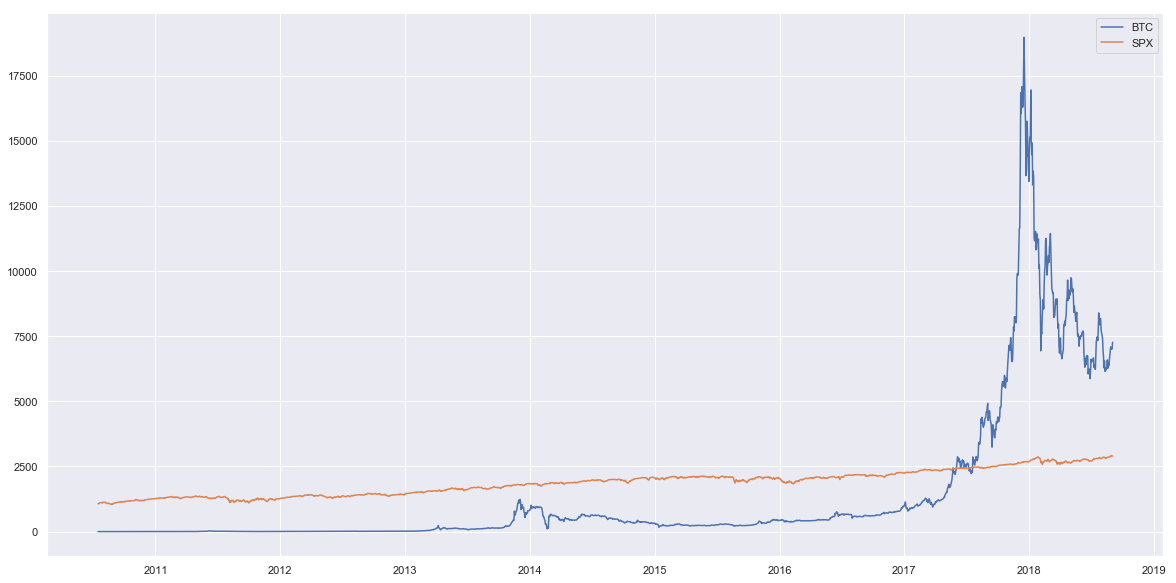

In [70]:
df.plot()

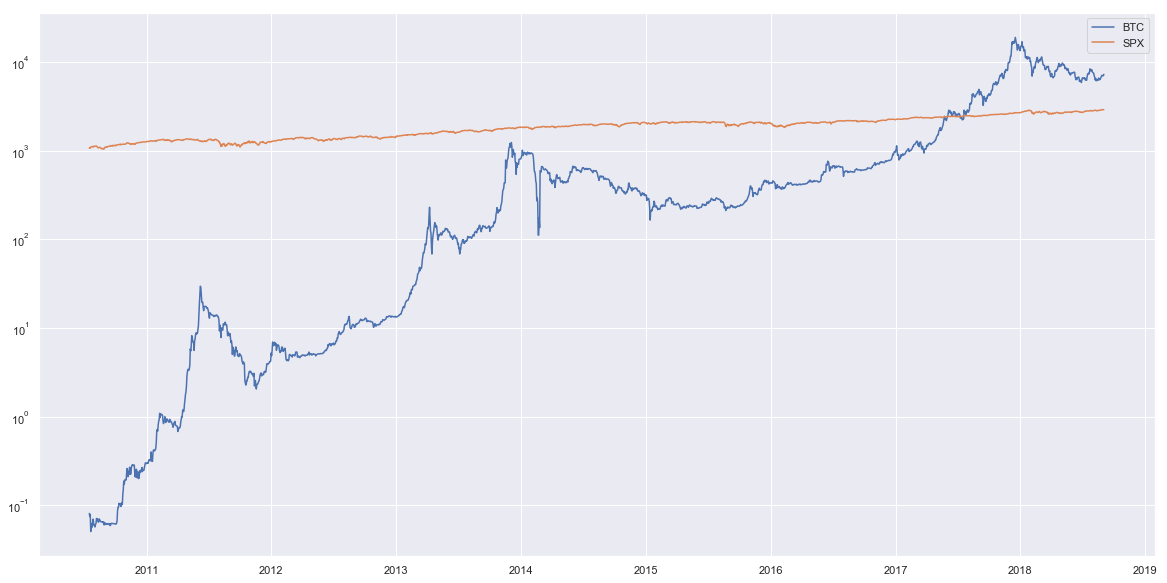

In [71]:
df.plot(logy=True)

### Aggregate Correlation

In [68]:
df.corr()

,BTC,SPX
BTC,1.000000,0.692776
SPX,0.692776,1.000000


In [72]:
df.pct_change(1).corr()

,BTC,SPX
BTC,1.000000,0.023072
SPX,0.023072,1.000000


In [73]:
df.pct_change(7).corr()

,BTC,SPX
BTC,1.000000,0.068388
SPX,0.068388,1.000000


In [74]:
df.pct_change(30).corr()

,BTC,SPX
BTC,1.00000,0.07862
SPX,0.07862,1.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123c9cfd0>,
      dtype=object)

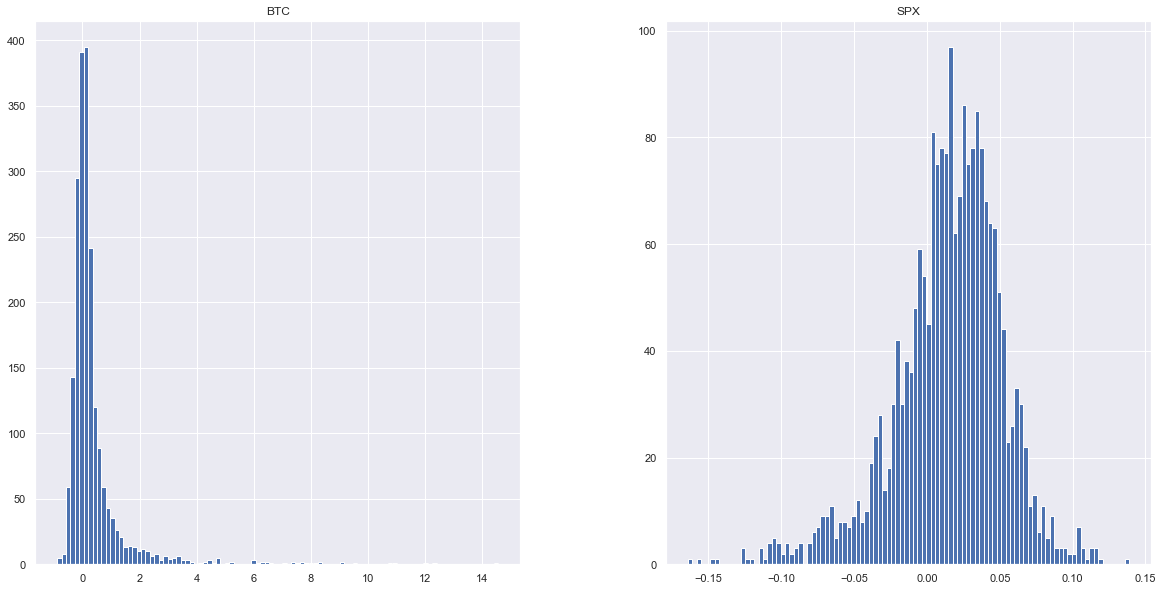

In [84]:
df.pct_change(30).hist(bins=100)

Returns from btc are extremely positively skewed while returns from the S&P are negatively skewed. 

In [110]:
rolling_corr.index.get_level_values(1)[:5]

Index(['BTC', 'SPX', 'BTC', 'SPX', 'BTC'], dtype='object')

### Rolling correlation

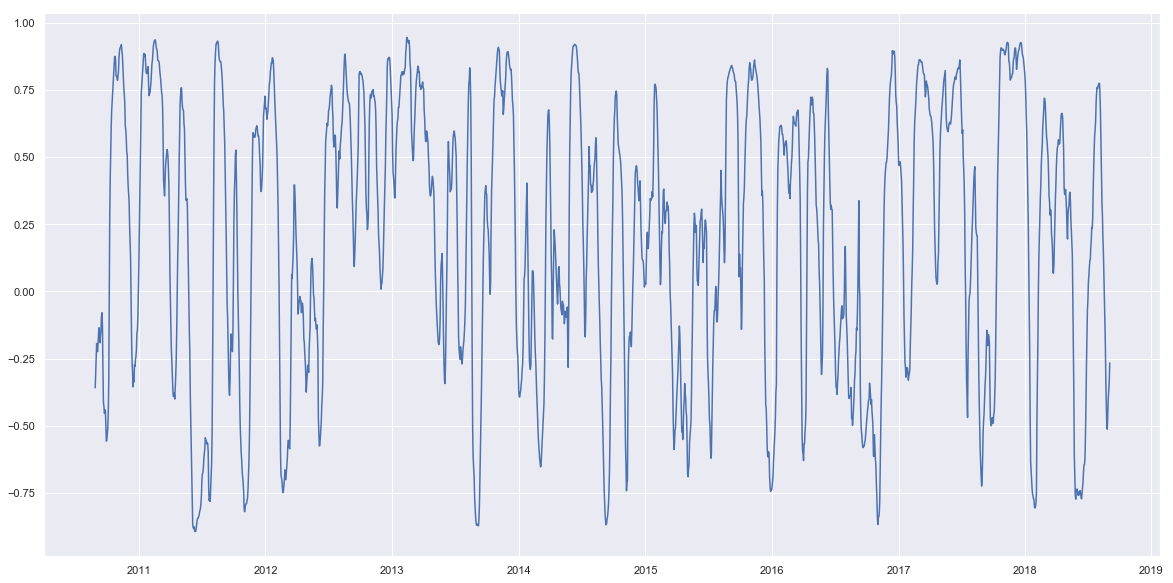

In [147]:
rolling_corr = df.rolling(30).corr().reset_index(1)
rolling_corr = rolling_corr[rolling_corr.level_1=='BTC'].SPX
rolling_corr.plot()

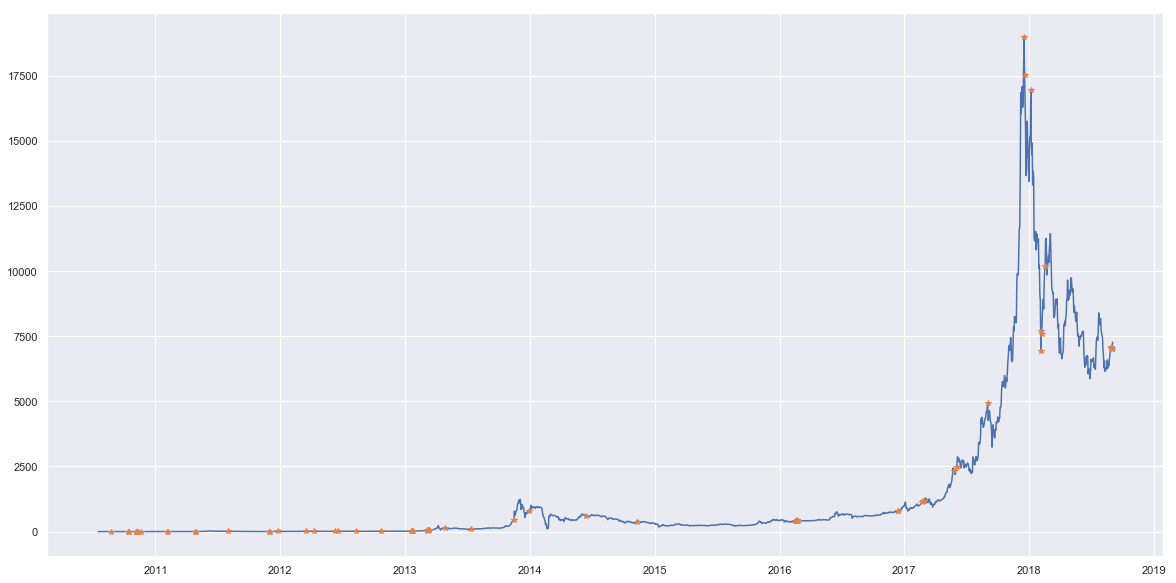

In [128]:
btc[rolling_corr.index].plot()
btc[rolling_corr.index][rolling_corr>.9].plot(marker='*', ls='')

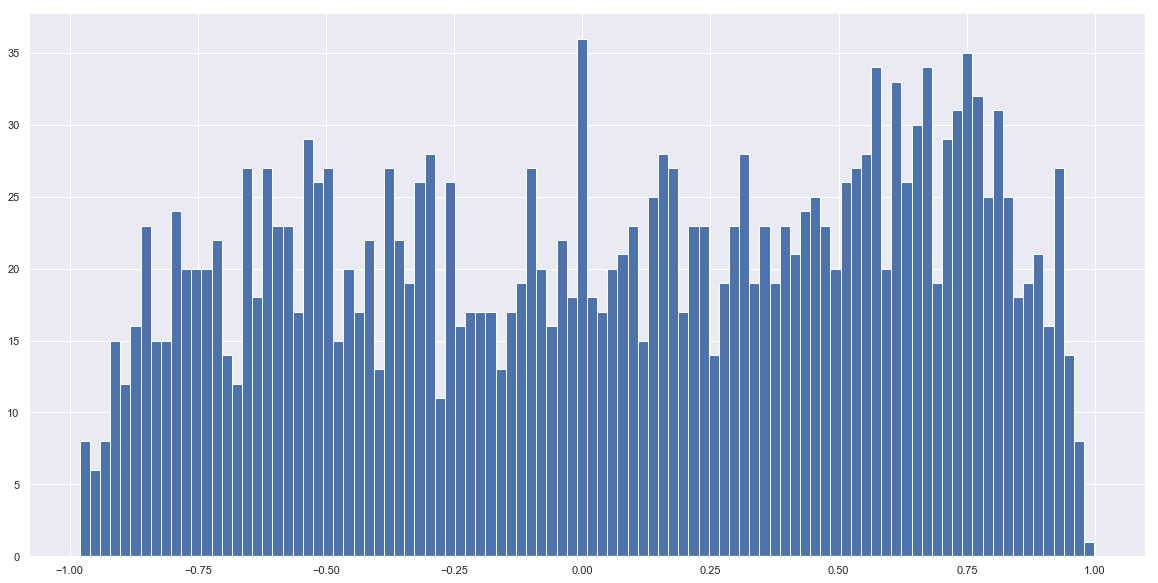

In [129]:
rolling_corr.hist(bins=100)

### Yearly correlations

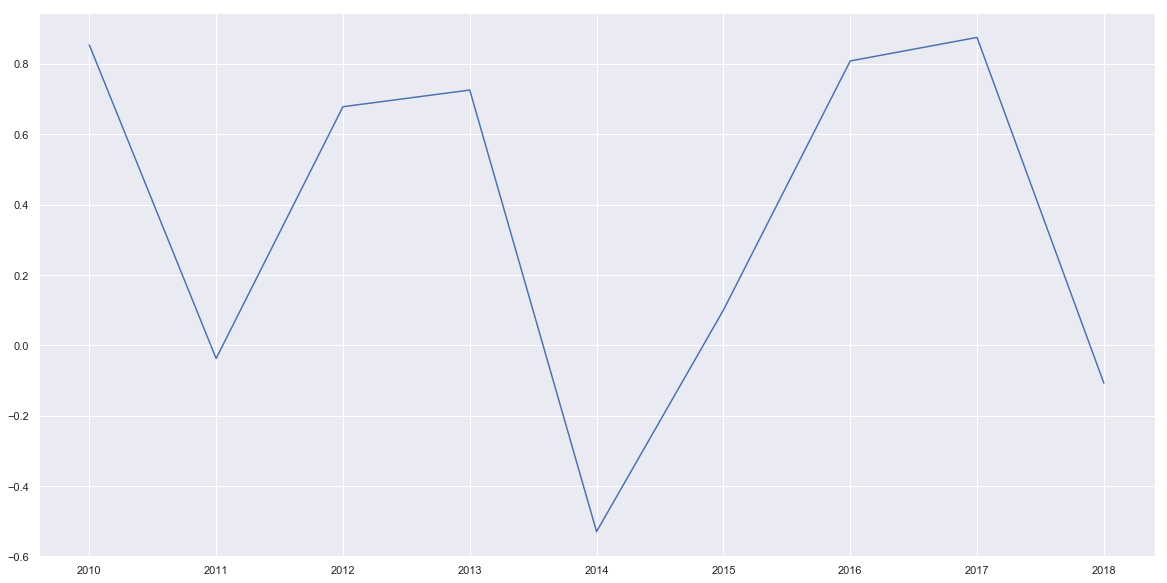

In [133]:
yearly_corr = df.groupby(df.index.year).corr().reset_index(1)
yearly_corr = yearly_corr[yearly_corr.level_1=='BTC'].SPX
yearly_corr.plot()

### Monthly correlations

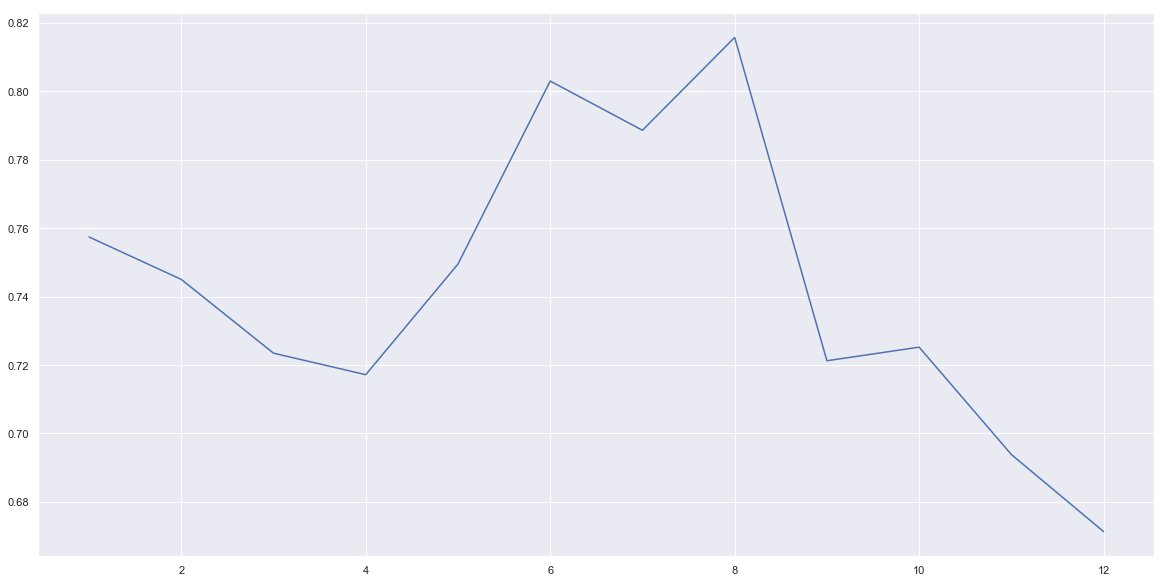

In [134]:
monthly_corr = df.groupby(df.index.month).corr().reset_index(1)
monthly_corr = monthly_corr[monthly_corr.level_1=='BTC'].SPX
monthly_corr.plot()

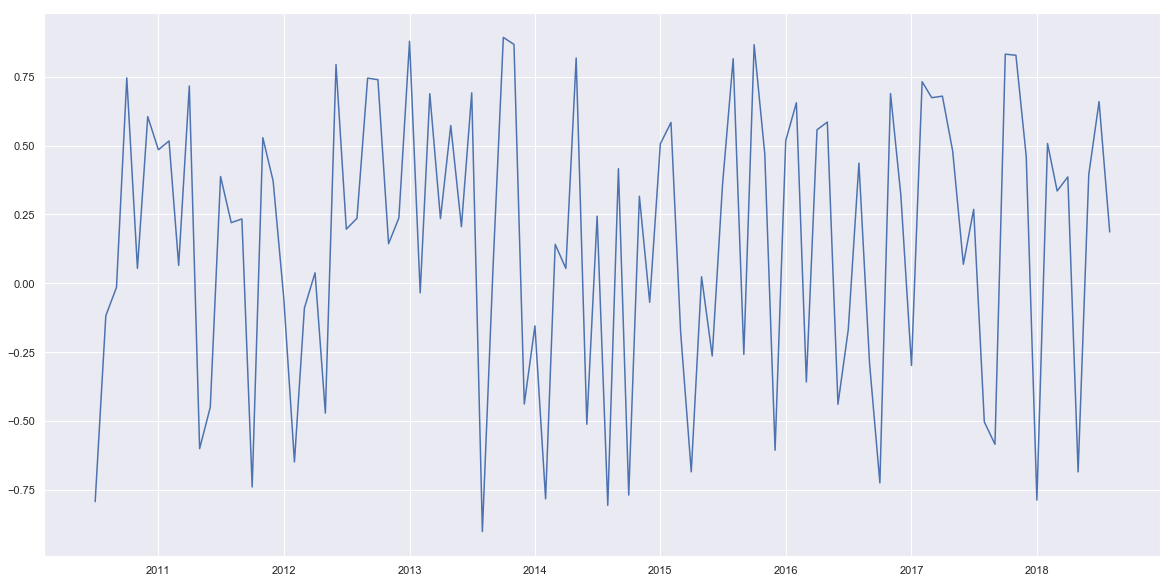

In [149]:
monthly_corr = df.groupby([df.index.year, df.index.month]).corr().reset_index(2)
monthly_corr = monthly_corr[monthly_corr.level_2=='BTC'].SPX
monthly_corr.index = [date(i[0],i[1],1) for i in monthly_corr.index]
monthly_corr.plot()

### Weekly correlations 

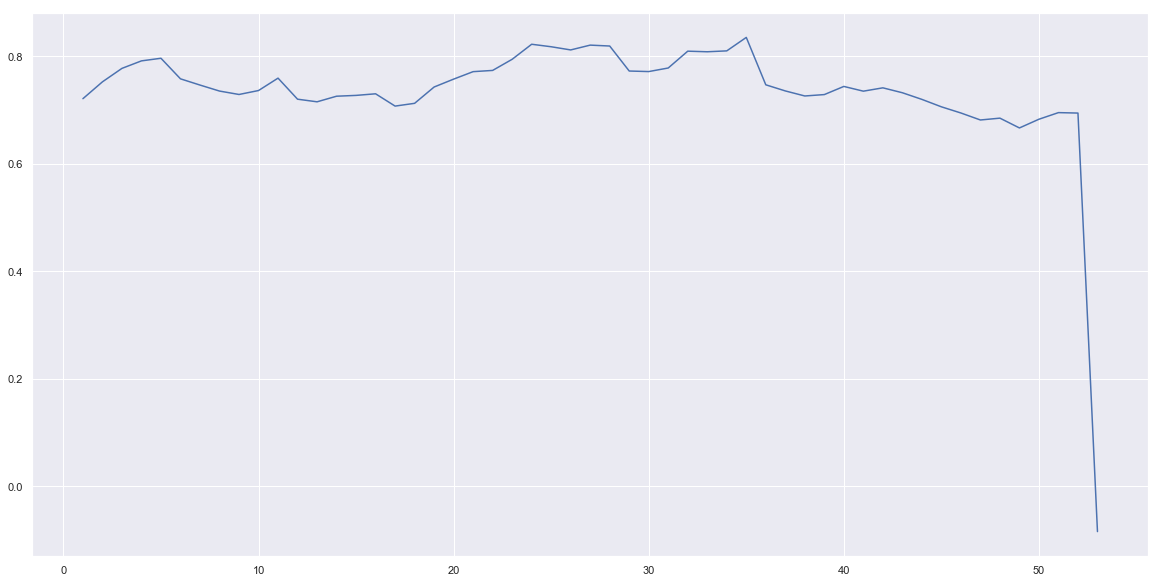

In [151]:
weekly_corr = df.groupby(df.index.week).corr().reset_index(1)
weekly_corr = weekly_corr[weekly_corr.level_1=='BTC'].SPX
weekly_corr.plot()

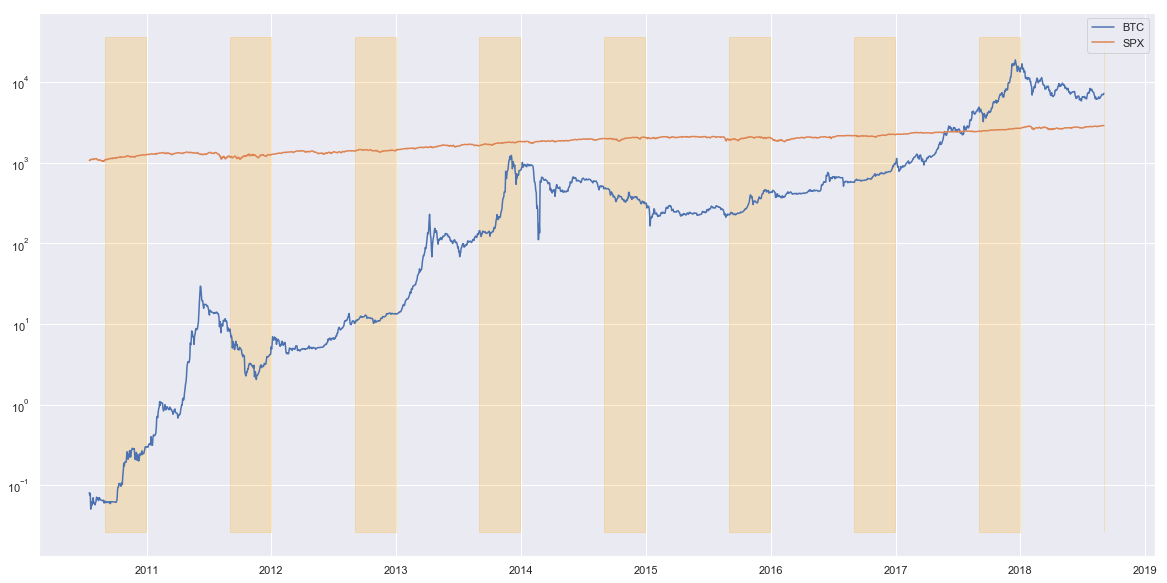

In [160]:
ax = df.plot(logy=True)
ymin, ymax = ax.get_ybound()
plt.fill_between(df.index, ymin, ymax, where=df.index.month>8, alpha=.2, color='orange')